## Prepare data files

In [4]:
import os
from os import listdir
from os.path import isfile, join

data_dir = 'dataset/'

data_files = []

data_files = [join(data_dir, f) for f in listdir(data_dir) if isfile(join(data_dir, f)) if '.npz' in f]

data_files.sort()

print('total data files : ', len(data_files))


total data files :  1282


## Hyperparameters declaration

In [5]:
IntervalDim = 100

VelocityDim = 32
VelocityOffset = IntervalDim

NoteOnDim = NoteOffDim = 128
NoteOnOffset = IntervalDim + VelocityDim
NoteOffOffset = IntervalDim + VelocityDim + NoteOnDim

EventDim = IntervalDim + VelocityDim + NoteOnDim + NoteOffDim # 388

Time = 650

EmbeddingDim = 512

HeadDim = 32
Heads = 16
ContextDim = HeadDim * Heads # 512


## Data load

x shape :  (650,)
y shape :  (650,)
[ 18 172 214   4 342  15 169 211   4 339   4 168 212   5 340   5 171 211
   8 339   1 163 212   7 183 214   1 340   2 342  18 179 211   5 339  16
 188 183   0 172 171   1 188 207   3 311   1 299  31 335   7 196 195   1
 183 183  32 323   3 311   2 186 196   0 185 208   3 324   3 336  32 175
 181   0 181 193   0 197 208   0 198 220   6 321   0 309  32 172 179   1
 336   0 188 191   1 348   3 307   1 319  35 184 219   0 195 207   1 196
 203   2 182 191   3 335   0 347  33 319   1 331   0 195 205   5 333  32
 189 202   0 195 205   0 175 190   0 192 217   3 330   5 318  30 345   0
 333   1 178 176   0 190 188   5 304   0 316  33 195 203   1 186 200   0
 189 215   2 157 188   1 145 187   2 331   1 343   4 315  26 328   1 316
   1 189 202   4 330  35 175 198   0 192 202   0 189 214   0 170 186   3
 326   5 314  30 177 173   0 187 185   1 342   1 330   3 313   1 301  36
 183 212   0 186 200   1 188 197   1 174 185   5 328   0 340  31 189 198
   3 325   2 32

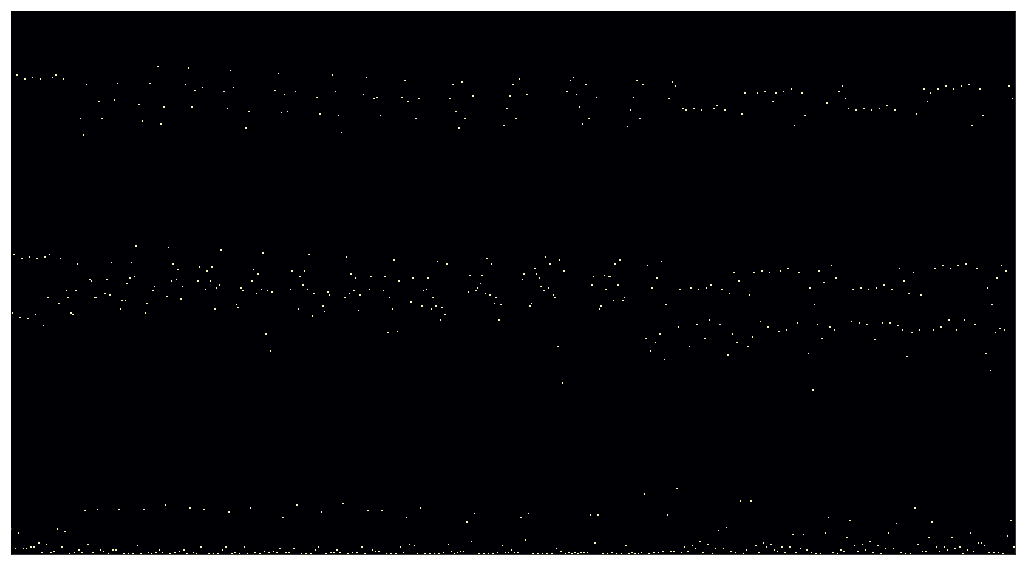

In [27]:
import numpy as np

def get_data(length=Time):
    index = np.random.randint(0, len(data_files))
    data = np.load(data_files[index])['eventlist']
    
    # time augmentation
    data[:, 0] *= np.random.uniform(0.95, 1.05)
    
    # absolute time to relative interval
    data[1:, 0] = data[1:, 0] - data[:-1, 0]
    data[0, 0] = 0
    
    # discretize interval into IntervalDim
    data[:, 0] = np.clip(np.round(data[:, 0] * IntervalDim), 0, IntervalDim - 1)
    
    # Note augmentation
    data[:, 2] += np.random.randint(-6, 6)
    data[:, 2] = np.clip(data[:, 2], 0, NoteOnDim)
    
    eventlist = []
    for d in data:
        # append interval
        interval = d[0]
        eventlist.append(interval)
    
        # note on case
        if d[1] == 1:
            velocity = d[3] + VelocityOffset
            note = d[2] + NoteOnOffset
            eventlist.append(velocity)
            eventlist.append(note)
            
        # note off case
        elif d[1] == 0:
            note = d[2] + NoteOffOffset
            eventlist.append(note)
            
    eventlist = np.array(eventlist).astype(np.int)
    
    if len(eventlist) > (length+1):
        start_index = np.random.randint(0, len(eventlist) - (length+1))
        eventlist = eventlist[start_index:start_index+(length+1)]
        
    # pad zeros
    if len(eventlist) < (length+1):
        pad = (length+1) - len(eventlist)
        eventlist = np.pad(eventlist, (pad, 0), 'constant')
        
    x = eventlist[:length]
    y = eventlist[1:length+1]
    
    return x, y
    
x, y = get_data()
print('x shape : ', x.shape)
print('y shape : ', y.shape)
print(x)
print(y)
    
    
roll = np.zeros([len(x), EventDim])
for t, _x in enumerate(x):
    roll[t, _x] = 1

plt.figure(figsize=[18, 10])
librosa.display.specshow(roll.T)
plt.show()

## Model

In [7]:
# thanks to @openai: https://github.com/openai/gpt-2/blob/master/src/model.py
def shape_list(x):
    """Deal with dynamic shape in tensorflow cleanly."""
    static = x.shape.as_list()
    dynamic = tf.shape(x)
    return [dynamic[i] if s is None else s for i, s in enumerate(static)]

def model(inputs):
    with tf.variable_scope('model'):
        # inputs : [Batch, Time, EmbeddingDim]
        
        Batch, _, _ = shape_list(inputs)
        
        # [Heads, Batch, Time, HeadDim]
        Q = tf.stack([tf.layers.dense(inputs, HeadDim, use_bias=False) for _ in range(Heads)])
        K = tf.stack([tf.layers.dense(inputs, HeadDim, use_bias=False) for _ in range(Heads)])
        V = tf.stack([tf.layers.dense(inputs, HeadDim, use_bias=False) for _ in range(Heads)])
        
        '''
        [E_(-T+1), ..., E_0]
        '''
        E = tf.get_variable('E', [Heads, Time, HeadDim])
        
        # [Heads, Batch * Time, HeadDim]
        Q_ = tf.reshape(Q, [Heads, Batch * Time, HeadDim])
        
        # [Heads, Batch * Time, Time]
        S = tf.matmul(Q_, E, transpose_b=True)
        # [Heads, Batch, Time, Time]
        S = tf.reshape(S, [Heads, Batch, Time, Time])
        # [Heads, Batch, Time, Time+1]
        S = tf.pad(S, ((0, 0), (0, 0), (0, 0), (1, 0)))
        # [Heads, Batch, Time+1, Time]
        S = tf.reshape(S, [Heads, Batch, Time+1, Time])
        # [Heads, Batch, Time, Time]
        S = S[:, :, 1:]
        
        # [Heads, Batch, Time, Time]
        attention = (tf.matmul(Q, K, transpose_b=True) + S) / np.sqrt(HeadDim)
        
        '''
        # [Time, Time]  [[1 0 0 0]
                         [1 1 0 0]
                         [1 1 1 0]
                         [1 1 1 1]]
        '''
        mask = tf.matrix_band_part(tf.ones([Time, Time]), -1, 0)
        
        # [Heads, Batch, Time, Time]
        attention = attention * mask - tf.cast(1e10, attention.dtype) * (1-mask)
        # [Heads, Batch, Time, Time]
        score = tf.nn.softmax(attention, axis=3)
        
        # [Heads, Batch, Time, HeadDim]
        context = tf.matmul(score, V)
        # [Batch, Time, Heads, HeadDim]
        context = tf.transpose(context, [1, 2, 0, 3])
        # [Batch, Time, ContextDim]
        context = tf.reshape(context, [Batch, Time, ContextDim])
        # [Batch, Time, ContextDim]
        context = tf.layers.dense(context, ContextDim, tf.nn.relu)
        # [Batch, Time, EventDim]
        logits = tf.layers.dense(context, EventDim)
        
        return logits
    

## Draw Graph

In [8]:
import tensorflow as tf
tf.reset_default_graph()

'''INPUTS'''
# [Batch, Time]
inputs = tf.placeholder(dtype=tf.int32, shape=[None, Time])
# [Batch, Time]
targets = tf.placeholder(dtype=tf.int32, shape=[None, None])

# [Batch, Time, EventDim], for the use of visualization
inputs_onehot = tf.one_hot(inputs, axis=2, depth=EventDim)

'''EMBEDDING'''
embedding = tf.get_variable('embedding', [EventDim, EmbeddingDim])
# [Batch, Time, EventDim]
inputs_embedding = tf.gather(embedding, inputs)

'''GET LOGITS'''
# [Batch, Time, EventDim]
logits = model(inputs_embedding)

# for the use of visualization
probs = tf.nn.softmax(logits, axis=2)

'''LOSS'''
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=targets, logits=logits)
loss = tf.reduce_mean(cross_entropy)

'''SAMPLING'''
dist = tf.distributions.Categorical(logits=logits[:, -1])
# [Batch, 1]
sample = dist.sample()

'''TRAIN'''
global_step = tf.Variable(0, name='global_step')
learning_rate = tf.Variable(1e-3, name='learning_rate')
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step)

'''SESSION OPEN'''

sess_config = tf.ConfigProto()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9, visible_device_list= '0')
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(tf.global_variables_initializer())

print('graph created')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Use tf.random.categorical instead.
Instructions for updating:
Use tf.cast instead.
graph created


In [9]:
load_dir = 'save/music-transformer'
save_dir = 'save/music-transformer'

saver = tf.train.Saver()

if True:
    restore_file = tf.train.latest_checkpoint(load_dir)
    if restore_file is not None:
        saver.restore(sess, restore_file)
        print("Model restored.")
    else:
        print('model not exist.')
        

model not exist.


In [10]:
from tensorboardX import SummaryWriter

class Logger(SummaryWriter):
    def __init__(self, logdir):
        super(Logger, self).__init__(logdir)

    def log(self, log_string, value, iteration):
            self.add_scalar(log_string, value, iteration)
            
logger = Logger(save_dir)            

In [ ]:
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import librosa.display
from time import sleep
import time

batch_size = 8
def get_batch_data(batch_size, time):
    _inputs = []
    _targets = []
    for _ in range(batch_size):
        x, y = get_data(time)
        _inputs.append(x)
        _targets.append(y)
        
    _inputs = np.stack(_inputs)
    _targets = np.stack(_targets)
    
    return _inputs, _targets
    
while(True):
    for _ in range(100):
        _inputs, _targets = get_batch_data(batch_size, Time)
        print(_inputs.shape, _targets.shape)
        
        _, _global_step, _loss = sess.run([train_step, global_step, loss], 
                                          feed_dict={inputs: _inputs, 
                                                     targets: _targets,
                                                     learning_rate: 1e-3})
        print('step : ', _global_step, 'loss : ', _loss)
        
        if _global_step % 10 == 0:
            logger.log('loss', _loss, _global_step)
        
        if _global_step % 1000 == 0:
            save_path = saver.save(sess, save_dir + '/checkpoint', global_step=_global_step)
            print("Model saved in path: %s" % save_path)
        
    clear_output()
    
    _inputs_onehot, _probs = sess.run([inputs_onehot, probs], feed_dict={inputs: _inputs})
    
    plt.figure(figsize=[18, 10])
    librosa.display.specshow(_inputs_onehot[0].T)
    plt.show()
    
    plt.figure(figsize=[18, 10])
    librosa.display.specshow(_probs[0].T)
    plt.show()
    
    

(8, 650) (8, 650)
step :  1399 loss :  3.9531817
(8, 650) (8, 650)
step :  1400 loss :  3.77027
(8, 650) (8, 650)
step :  1401 loss :  3.7222223
(8, 650) (8, 650)
step :  1402 loss :  3.7977307
(8, 650) (8, 650)
step :  1403 loss :  3.9086936
(8, 650) (8, 650)
step :  1404 loss :  3.835322
(8, 650) (8, 650)
step :  1405 loss :  3.847772
(8, 650) (8, 650)
step :  1406 loss :  3.752189
